#Image Classification & Object Detection

In [ ]:
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Subset
from torchvision.datasets import Places365
import torchvision.transforms as transforms
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import class_distribution

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Training Dataset

In [ ]:
def load_images_from_folder(folder, size_per_class=100):
    images = []
    labels = []

    for class_folder in os.listdir(folder):
      full_class_folder = os.path.join(folder, class_folder)
      image_paths = os.listdir(full_class_folder)[:size_per_class]

      for filename in image_paths:
          img = cv2.imread(os.path.join(full_class_folder, filename), cv2.IMREAD_GRAYSCALE)
          if img is not None:
              images.append(img)
              labels.append(class_folder)

    return images, labels

In [ ]:
# Load the training data
# https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download
data_size_per_class = 800
(loaded_data, target_labels) = load_images_from_folder("/content/drive/MyDrive/OAE5133: Image Proc/Tutorial 2/images", size_per_class=data_size_per_class)

# Select classes and filter the dataset
classes = list(set(target_labels))
dataset_size = len(loaded_data)

print("Classes: ", classes)

Classes:  ['sea', 'mountain', 'street']


# Generate SIFT and ORB features from images

In [ ]:
# Create SIFT, SURF, ORB feature extractor
sift = cv2.SIFT_create()
# surf = cv2.xfeatures2d.SURF_create()
orb = cv2.ORB_create()

In [ ]:
all_sift_descriptors = []
n_sift_descriptors_per_image = []

# all_surf_descriptors = []
# n_surf_descriptors_per_image = []

all_orb_descriptors = []
n_orb_descriptors_per_image = []

for i in range(dataset_size):
    image, label = loaded_data[i], target_labels[i]

    # Extract SIFT features from an image
    _, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
      n_sift_descriptors_per_image.append(0)
      print(f"[WARN] No SIFT features extracted from image #{i}")
    else:
      all_sift_descriptors.extend(descriptors)
      n_sift_descriptors_per_image.append(descriptors.shape[0])

    # Extract ORB features from an image
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
      n_orb_descriptors_per_image.append(0)
      print(f"[WARN] No ORB features extracted from image #{i}")
    else:
      all_orb_descriptors.extend(descriptors)
      n_orb_descriptors_per_image.append(descriptors.shape[0])


[WARN] No ORB features extracted from image #4
[WARN] No ORB features extracted from image #10
[WARN] No SIFT features extracted from image #147
[WARN] No ORB features extracted from image #147
[WARN] No SIFT features extracted from image #362
[WARN] No SIFT features extracted from image #364
[WARN] No ORB features extracted from image #364
[WARN] No SIFT features extracted from image #525
[WARN] No SIFT features extracted from image #687
[WARN] No ORB features extracted from image #687
[WARN] No SIFT features extracted from image #777
[WARN] No ORB features extracted from image #793
[WARN] No ORB features extracted from image #978


## SIFT - K-means clustering to create Bag of Visual Words (BoVW)
For each parameter (cluster number) chosen:
1. Generate BoVW histogram from SIFT features of each image.
2. The histograms are used as the input features of images for trained with Support Vector Machine (SVM).
3. Test the performance of SVM.

In [ ]:
cluster_numbers = [20, 60, 100, 140, 180]
test_scores = []
test_confusion_matrices = []

for clst_num in cluster_numbers:
  print("Number of Clusters: ", clst_num)

  # Cluster features using k-means
  kmeans_sift = MiniBatchKMeans(n_clusters=clst_num, random_state=0, n_init=5).fit(all_sift_descriptors)

  # Histogram computation for SIFT features
  image_features = []
  start = 0
  for i in range(dataset_size):
      histogram = np.zeros(len(kmeans_sift.cluster_centers_))
      if n_sift_descriptors_per_image[i] > 0:
        cluster_result = kmeans_sift.predict(all_sift_descriptors[start:start + n_sift_descriptors_per_image[i]])
        for j in cluster_result:
            histogram[j] += 1

      image_features.append(histogram)
      start += n_sift_descriptors_per_image[i]

  # Normalize features
  scaler = StandardScaler().fit(image_features)
  image_features = scaler.transform(image_features)

  # Train SVM
  X_train, X_test, y_train, y_test = train_test_split(np.array(image_features), np.array(target_labels), test_size=0.1, random_state=42, shuffle=True)
  print("Shape of Training Data: ", X_train.shape)
  print("Shape of Testing Data: ", X_test.shape)

  clf = svm.SVC(class_weight='balanced')
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  # Test SVM
  test_scores.append(clf.score(X_test, y_test))

  # Compute classification report
  print(classification_report(y_test, y_pred), "\n")

  # Compute the confusion matrix
  test_confusion_matrices.append(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    mountain       0.58      0.66      0.62        70
         sea       0.71      0.62      0.67        88
      street       0.79      0.80      0.80        82

    accuracy                           0.70       240
   macro avg       0.69      0.70      0.69       240
weighted avg       0.70      0.70      0.70       240
 

Number of Clusters:  100
Shape of Training Data:  (2160, 100)
Shape of Testing Data:  (240, 100)
              precision    recall  f1-score   support

    mountain       0.56      0.69      0.62        70
         sea       0.73      0.56      0.63        88
      street       0.77      0.83      0.80        82

    accuracy                           0.69       240
   macro avg       0.69      0.69      0.68       240
weighted avg       0.70      0.69      0.69       240
 

Number of Clusters:  140
Shape of Training Data:  (2160, 140)
Shape of Testing Data:  (240, 140)
              precision    recall  f1-sc

In [ ]:
score_df = pd.DataFrame({
    "Cluster Number": cluster_numbers,
    "Scores": test_scores
})

score_df

,Cluster Number,Scores
0,20,0.645833
1,60,0.695833
2,100,0.687500
3,140,0.725000
4,180,0.708333


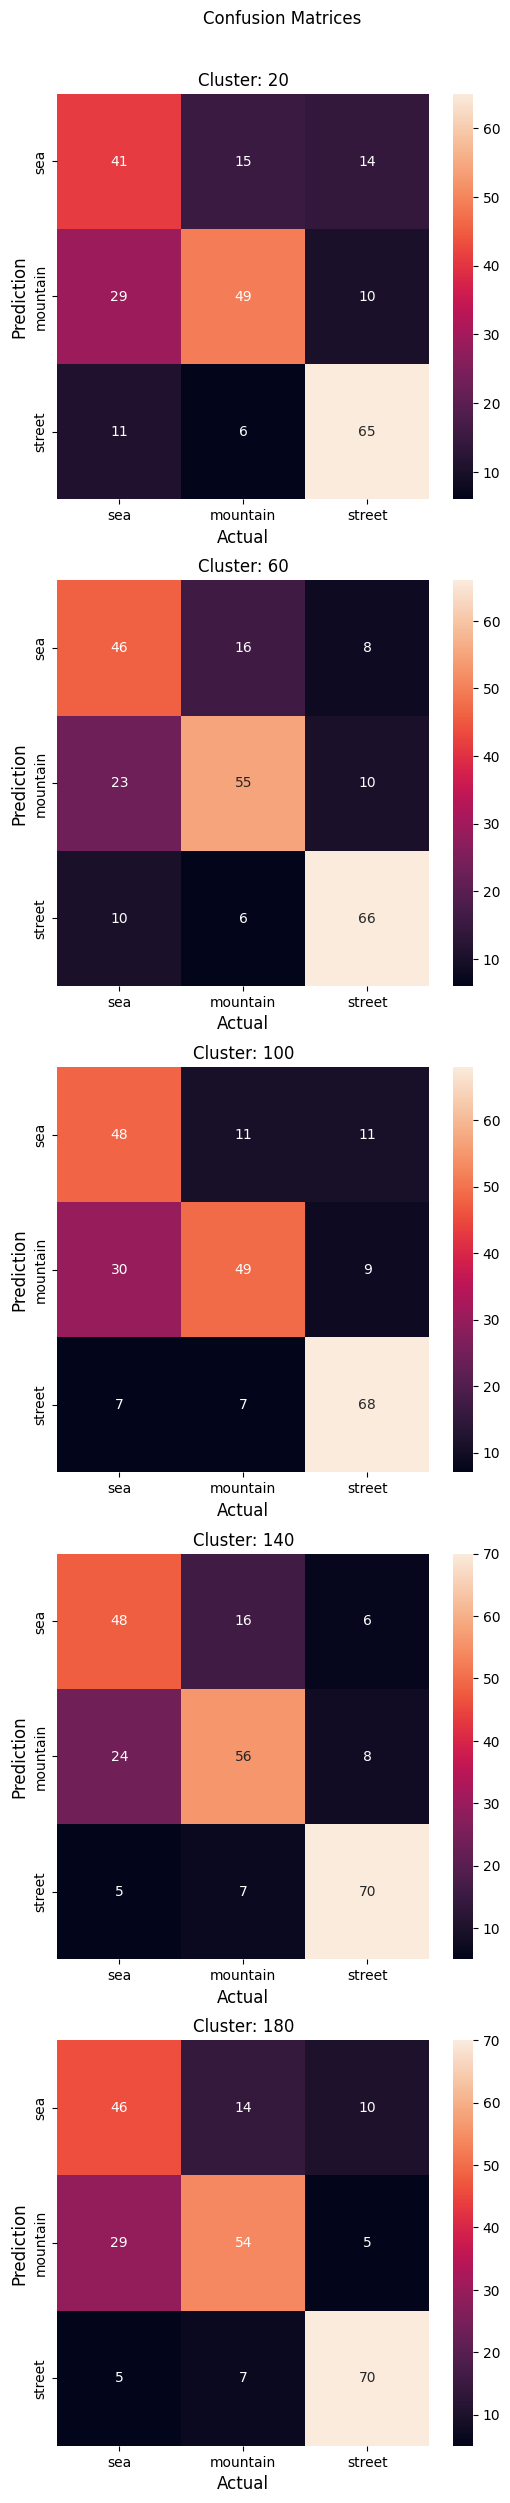

In [ ]:
fig, axes = plt.subplots(len(cluster_numbers), figsize=(6, 28))
fig.suptitle('Confusion Matrices')
plt.subplots_adjust(top=0.95)

for i, cls in enumerate(cluster_numbers):
  # Plot the confusion matrix.
  cm_array_df = pd.DataFrame(test_confusion_matrices[i], index=classes, columns=classes)
  sns.heatmap(cm_array_df, annot=True, ax=axes[i])
  axes[i].set_ylabel('Prediction',fontsize=12)
  axes[i].set_xlabel('Actual',fontsize=12)
  axes[i].set_title(f'Cluster: {cls}')
  # axes[i].set_xticks([0, 1, 2], labels=classes)
  # axes[i].set_yticks([0, 1, 2], labels=classes);

plt.show()

## ORB - K-means clustering to create Bag of Visual Words (BoVW)
For each parameter (cluster number) chosen:
1. Generate BoVW histogram from ORB features of each image.
2. The histograms are used as the input features of images for trained with Support Vector Machine (SVM).
3. Test the performance of SVM with accuracy and confusion matrix.


In [ ]:
cluster_numbers = [20, 60, 100, 140, 180]
test_scores = []
test_confusion_matrices = []

for clst_num in cluster_numbers:
  print("Number of Clusters: ", clst_num)

  # kmeans_surf = MiniBatchKMeans(n_clusters=40, random_state=0).fit(all_surf_descriptors)
  kmeans_orb = MiniBatchKMeans(n_clusters=clst_num, random_state=0, n_init=5).fit(all_orb_descriptors)

  # Histogram computation for ORB features
  image_features = []
  start = 0
  for i in range(dataset_size):
      histogram = np.zeros(len(kmeans_orb.cluster_centers_))
      if n_orb_descriptors_per_image[i] > 0:
        cluster_result = kmeans_orb.predict(all_orb_descriptors[start:start + n_orb_descriptors_per_image[i]])
        for j in cluster_result:
            histogram[j] += 1

      image_features.append(histogram)
      start += n_orb_descriptors_per_image[i]

  # Normalize features
  scaler = StandardScaler().fit(image_features)
  image_features = scaler.transform(image_features)

  # Train SVM
  X_train, X_test, y_train, y_test = train_test_split(np.array(image_features), np.array(target_labels), test_size=0.1, random_state=42, shuffle=True)
  print("Shape of Training Data: ", X_train.shape)
  print("Shape of Testing Data: ", y_train.shape)

  clf = svm.SVC(class_weight='balanced')
  clf.fit(X_train, y_train)

  # Test SVM
  y_pred = clf.predict(X_test)
  test_scores.append(clf.score(X_test, y_test))

  # Compute classification report
  print(classification_report(y_test, y_pred), "\n")

  # Compute the confusion matrix
  test_confusion_matrices.append(confusion_matrix(y_test, y_pred))


Number of Clusters:  20
Shape of Training Data:  (2160, 20)
Shape of Testing Data:  (2160,)
              precision    recall  f1-score   support

    mountain       0.46      0.41      0.44        70
         sea       0.70      0.62      0.66        88
      street       0.64      0.77      0.70        82

    accuracy                           0.61       240
   macro avg       0.60      0.60      0.60       240
weighted avg       0.61      0.61      0.61       240
 

Number of Clusters:  60
Shape of Training Data:  (2160, 60)
Shape of Testing Data:  (2160,)
              precision    recall  f1-score   support

    mountain       0.51      0.46      0.48        70
         sea       0.68      0.58      0.63        88
      street       0.65      0.80      0.72        82

    accuracy                           0.62       240
   macro avg       0.61      0.61      0.61       240
weighted avg       0.62      0.62      0.61       240
 

Number of Clusters:  100
Shape of Training Data:  

In [ ]:
score_df = pd.DataFrame({
    "Cluster Number": cluster_numbers,
    "Scores": test_scores
})

score_df

,Cluster Number,Scores
0,20,0.612500
1,60,0.620833
2,100,0.604167
3,140,0.645833
4,180,0.633333


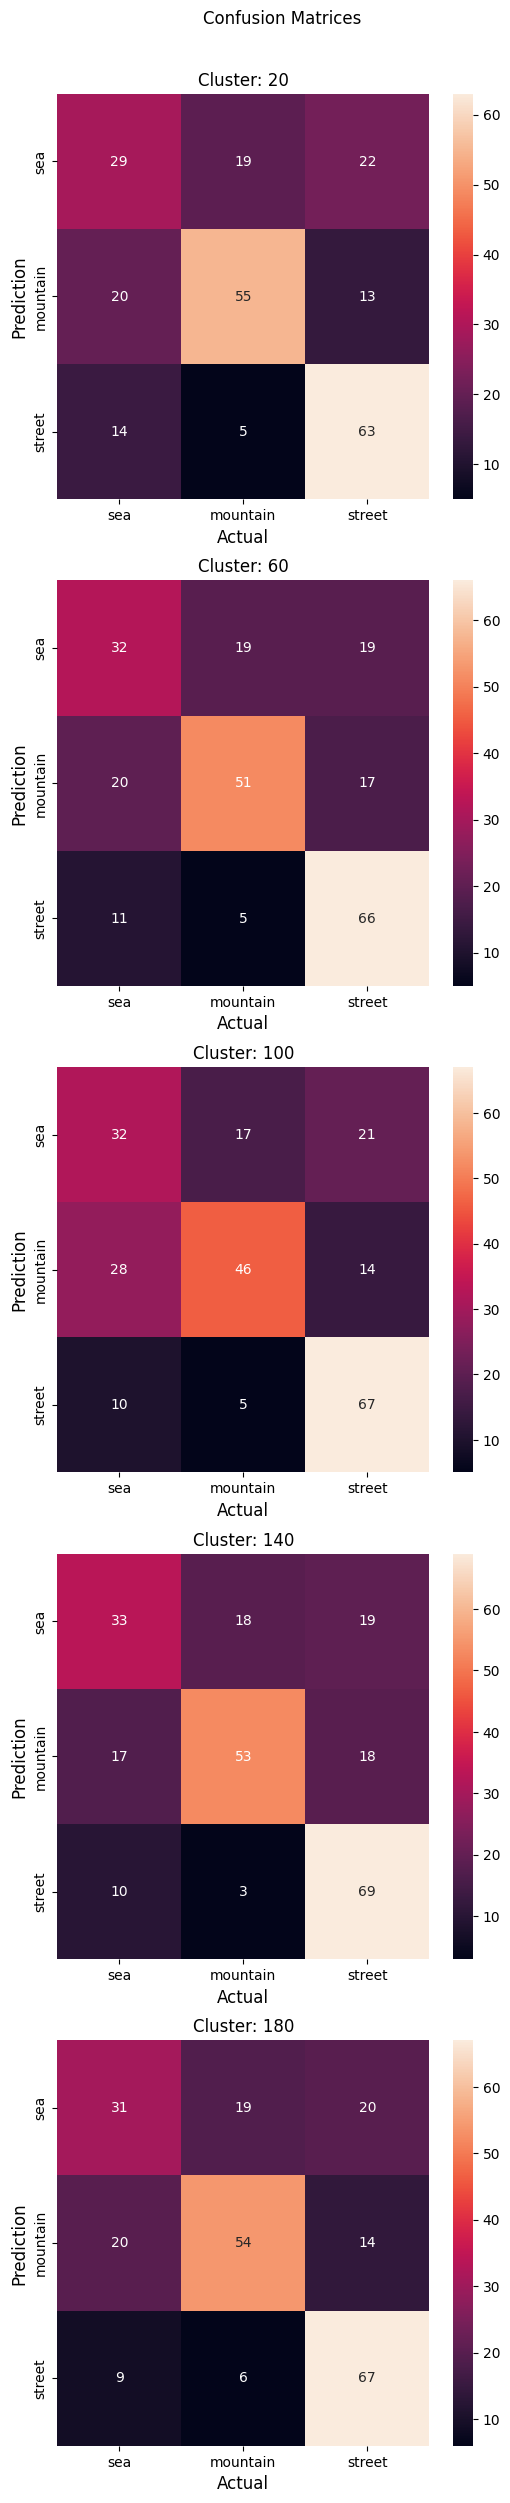

In [ ]:
fig, axes = plt.subplots(len(cluster_numbers), figsize=(6, 28))
fig.suptitle('Confusion Matrices')
plt.subplots_adjust(top=0.95)

for i, cls in enumerate(cluster_numbers):
  # Plot the confusion matrix.
  cm_array_df = pd.DataFrame(test_confusion_matrices[i], index=classes, columns=classes)
  sns.heatmap(cm_array_df, annot=True, ax=axes[i])
  axes[i].set_ylabel('Prediction',fontsize=12)
  axes[i].set_xlabel('Actual',fontsize=12)
  axes[i].set_title(f'Cluster: {cls}')
  # axes[i].set_xticks([0, 1, 2], labels=classes)
  # axes[i].set_yticks([0, 1, 2], labels=classes);

plt.show()